In [1]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    DataCollatorWithPadding,
    set_seed
)

import evaluate
import numpy as np
import torch.nn as nn
import math
import time
from tqdm import tqdm
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.special import softmax

/home/rydevera3/.virtualenvs/text-mining-titans/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ.get('CUDA_VISIBLE_DEVICES')

'0'

In [3]:
set_seed(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [4]:
ds = load_dataset("hate_speech_offensive")

ds = ds["train"]
ds = ds.train_test_split(test_size=0.1)
cls_freq = np.unique(ds["train"][:]['class'], return_counts=True)[1]

print(ds)
print(cls_freq)

Found cached dataset hate_speech_offensive (/home/rydevera3/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 467.54it/s]
Loading cached split indices for dataset at /home/rydevera3/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-cb96982b7bfdbcc4.arrow and /home/rydevera3/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-1bde663f7af89f3b.arrow


DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 22304
    })
    test: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 2479
    })
})
[ 1291 17296  3717]


In [5]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples["tweet"], max_length=512, padding="max_length", truncation=True)
    tokenized_inputs['labels'] = examples["class"]
    return tokenized_inputs

tokenized_ds = ds.map(preprocess_function, batched=True)
tokenized_ds = tokenized_ds.remove_columns("tweet")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading cached processed dataset at /home/rydevera3/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-e322ff108f0f7f05.arrow
Loading cached processed dataset at /home/rydevera3/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5/cache-2e10004282ef60e2.arrow


In [6]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
recall = evaluate.load("recall")
precision = evaluate.load("precision")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    predictions[predictions>0] = 1
    predictions = 1 - predictions
    labels_hate = copy.deepcopy(labels)
    labels[labels>0] = 1
    labels = 1 - labels
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1s = f1.compute(predictions=predictions, references=labels)
    rec = recall.compute(predictions=predictions, references=labels)
    pre = precision.compute(predictions=predictions, references=labels)
    return f1s

In [7]:
class CustomTrainer(Trainer):
    def __init__(self, weighted_training=False, **kwargs,):
        super().__init__(**kwargs)
        self.weighted_training = weighted_training

    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()

        if self.weighted_training:
            wts = sum(cls_freq)/torch.tensor(cls_freq)
            print("wts",wts)
        else:
            wts = torch.ones(3)

        criterion = torch.nn.CrossEntropyLoss(weight = wts).to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            train_pcacc_per_epoch = [0 for cls in range(3)]
            train_pccount_per_epoch = [0 for cls in range(3)]
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(inputs['input_ids'],attention_mask = inputs['attention_mask'])
                    # get the loss
                    loss = criterion(output['logits'], labels)
                    train_loss_per_epoch += loss.item()
                    #calculate gradients
                    loss.backward()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
                    for cls in range(3):
                        train_pcacc_per_epoch[cls] += (output['logits'].argmax(1)[labels==cls] == cls).sum().item()
                        train_pccount_per_epoch[cls] += sum(labels==cls)
                    
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            train_pcacc_per_epoch = [(train_pcacc_per_epoch[cls]/train_pccount_per_epoch[cls]).item() for cls in range(3)]
            
            
            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            eval_pcacc_per_epoch = [0 for cls in range(3)]
            eval_pccount_per_epoch = [0 for cls in range(3)]
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for step, inputs in enumerate(eval_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    with torch.no_grad():
                        output = model(inputs['input_ids'],attention_mask = inputs['attention_mask'])
                        loss = criterion(output['logits'], labels)
                        eval_loss_per_epoch += loss.item()
                        eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
                        for cls in range(3):
                            eval_pcacc_per_epoch[cls] += (output['logits'].argmax(1)[labels==cls] == cls).sum().item()
                            eval_pccount_per_epoch[cls] += sum(labels==cls)
            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
            eval_pcacc_per_epoch = [(eval_pcacc_per_epoch[cls]/eval_pccount_per_epoch[cls]).item() for cls in range(3)]
        
            
            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}% | Train Per Class Acc: {train_pcacc_per_epoch}')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}% | Eval Per Class Acc: {eval_pcacc_per_epoch}')
            train_loss.append(train_loss_per_epoch)
            eval_loss.append(eval_loss_per_epoch)
            train_acc.append(train_acc_per_epoch)
            eval_acc.append(eval_acc_per_epoch)
            train_pcacc.append(train_pcacc_per_epoch)
            eval_pcacc.append(eval_pcacc_per_epoch)
    
        print(f'Time: {(time.time()-start)/60:.3f} minutes')

In [8]:
# Use weighted CE loss
train_loss=[]
eval_loss=[]
train_acc=[]
eval_acc=[]
train_pcacc=[]
eval_pcacc=[]

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3,
    output_hidden_states=True
)
model.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="wce_model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    eval_accumulation_steps=4,
    fp16=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    weighted_training=True,
)

# import warnings
# warnings.filterwarnings("ignore")
trainer.train()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

wts tensor([17.2765,  1.2895,  6.0005])


Evaluation Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:30<00:00, 10.33batch/s]

	Train Loss: 0.495 | Train Acc: 84.99% | Train Per Class Acc: [0.5724244713783264, 0.8557469844818115, 0.919289767742157]
	Eval Loss: 0.445 | Eval Acc: 83.71% | Eval Per Class Acc: [0.6115108132362366, 0.8236536979675293, 0.966367781162262]
Time: 13.634 minutes


In [9]:
len(tokenized_ds['test'])

2479

In [50]:
from torch.utils.data import Dataset, DataLoader
import tqdm

class HW5Dataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    input_ids = torch.tensor(sample['input_ids'])
    attention_mask = torch.tensor(sample['attention_mask'])
    labels = torch.tensor(sample['labels'])
  
    return (input_ids, attention_mask, labels)

visualization_layer = nn.Sequential(
    model.classifier.dropout,
    model.classifier.dense,
    nn.Tanh(),
    # model.classifier.dropout,
    # model.classifier.out_proj
)

# Get the same outputs for the test data
test_data = HW5Dataset(data=tokenized_ds['test'])
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

test_outputs = []
test_logits = []
test_predictions = []
test_confidence = []
test_labels = []
test_softmax_predictions = []

model.eval()
# with torch.no_grad():
for index, (input_ids, attention_mask, labels) in tqdm.tqdm(enumerate(test_loader)):
    outputs = model(
        input_ids=input_ids.to(device),
        attention_mask=attention_mask.to(device),
    )
    output = model.roberta(
        input_ids=input_ids.to(device),
        attention_mask=attention_mask.to(device),
    )
    layer_embeds = output[0]
    layer_embeds = layer_embeds[:, 0, :]
    test_output = visualization_layer(layer_embeds)
    test_output = test_output.detach().cpu().numpy()
    test_outputs.append(test_output)

    # Get the predictions & confidence
    test_logits.append(outputs['logits'].detach().cpu().numpy())
    predictions = torch.softmax(outputs['logits'], dim=1)
    confidence, predicted_label = torch.max(predictions, dim=1)

    # Gather the data
    test_softmax_predictions.append(predictions.detach().cpu().numpy())
    test_predictions.append(predicted_label.detach().cpu().numpy())
    test_confidence.append(confidence.detach().cpu().numpy())
    test_labels.append(labels.detach().cpu().numpy())

test_outputs = np.vstack(test_outputs)
test_predictions = np.concatenate(test_predictions)
test_labels = np.concatenate(test_labels)
test_confidence = np.concatenate(test_confidence)
test_softmax_predictions = np.vstack(test_softmax_predictions)
test_logits = np.vstack(test_logits)

1240it [01:05, 18.95it/s]


In [51]:
test_outputs

array([[ 0.34523785, -0.04844125, -0.38360158, ..., -0.45290694,
         0.27544534,  0.14103979],
       [ 0.49257615,  0.15888484, -0.81337357, ...,  0.4829618 ,
         0.929035  ,  0.52149355],
       [ 0.45360944, -0.07711581, -0.708729  , ...,  0.17737032,
         0.8088132 ,  0.33699813],
       ...,
       [ 0.17338574, -0.24352714, -0.22630921, ..., -0.00392104,
         0.07220154,  0.19244377],
       [ 0.5165755 ,  0.01476697, -0.79937035, ...,  0.3546347 ,
         0.92140335,  0.47328082],
       [ 0.31480056, -0.23608217, -0.5375606 , ..., -0.28217363,
         0.39323685,  0.32360935]], dtype=float32)

In [52]:
test_logits

array([[ 2.414411  , -0.12114027, -1.7111986 ],
       [-0.21482123,  3.0504153 , -3.0146666 ],
       [ 0.8237471 ,  1.745054  , -2.4829347 ],
       ...,
       [ 1.2003447 , -0.5396658 , -0.15857011],
       [ 0.31611937,  2.6182988 , -3.0442839 ],
       [ 1.9982162 ,  0.31308934, -1.7409434 ]], dtype=float32)

In [84]:
# Get all of the outputs as a dataframe
df_output = pd.DataFrame()
df_output['tweet'] = ds['test']['tweet']

class_dict = {0: 'hate-speech', 1: 'offensive-language', 2: 'neither'}
class_color = {0: 'blue', 1: 'orange', 2: 'green'}
df_output['true_label'] = test_labels
df_output['true_label_color'] = df_output['true_label'].map(class_color)
df_output['true_label'] = df_output['true_label'].map(class_dict)

df_output['predicted_label'] = test_predictions
df_output['predicted_label'] = df_output['predicted_label'].map(class_dict)
df_output['correct_indicator'] = df_output['true_label'] == df_output['predicted_label']
df_output['alphas'] = test_confidence

df_output['conf_hate_speech'] = test_softmax_predictions[:, 0]
df_output['conf_offensive_language'] = test_softmax_predictions[:, 1]
df_output['conf_neither'] = test_softmax_predictions[:, 2]

df_output['input_text_length'] = df_output['tweet'].map(len)
df_output = df_output.sample(frac=1)

# writer = pd.ExcelWriter('./hw5_outputs.xlsx')
# df_output.to_excel(writer, index = False)
# writer.save()

In [85]:
df_output['correct_indicator'].sum() / len(df_output)

0.8374344493747479

In [86]:
df_output.head()

,tweet,true_label,true_label_color,predicted_label,correct_indicator,alphas,conf_hate_speech,conf_offensive_language,conf_neither,input_text_length
1722,@big_business_ lmao dog just type them out and...,offensive-language,orange,hate-speech,False,0.907605,0.907605,0.079263,0.013132,83
2130,@BloggerBoxing @Studhardt22 the Jacob and Josh...,offensive-language,orange,hate-speech,False,0.917190,0.917190,0.063388,0.019422,131
1192,RT @AmyRoseKathryn: Justice for British seagul...,neither,green,neither,True,0.986637,0.008518,0.004845,0.986637,152
104,RT @GossipCop: Charlie Sheen SLAMS Rihanna For...,neither,green,neither,True,0.982852,0.008425,0.008723,0.982852,145
1100,' Y'all complaining about thirst traps ? FR ? ...,offensive-language,orange,offensive-language,True,0.954582,0.040703,0.954582,0.004714,137


# Investigating Visualilzations

For this part of the homework we want to look at different visualizations of the dataset and the predicted errors. We will use t-SNE for visualization.

In [87]:
from sklearn.manifold import TSNE

In [88]:
%%time
tsne_dimension = TSNE(n_components=2)
test_tsne_dimension = tsne_dimension.fit_transform(test_outputs)

CPU times: user 43 s, sys: 1.26 s, total: 44.3 s
Wall time: 3.7 s


Text(0.5, 1.0, 'ClassifierHead Projection TSNE')

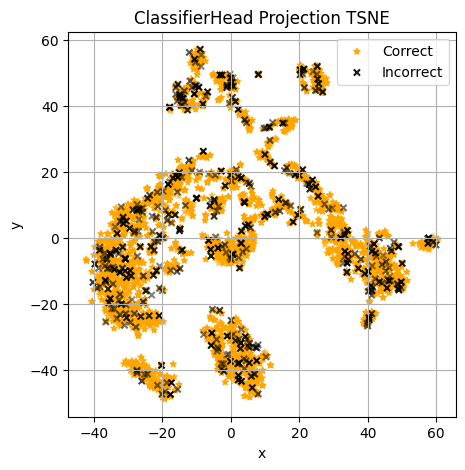

In [99]:
# Correct / incorrect
df_output['x'] = test_tsne_dimension[:, 0]
df_output['y'] = test_tsne_dimension[:, 1]

# Correct
correct_indicator_color = np.where(df_output['correct_indicator'], 'orange', 'black')
df_output['correct_indicator_color'] = correct_indicator_color
correct_df = df_output.loc[df_output['correct_indicator_color'] == 'orange']
ax = correct_df.plot.scatter(
    x='x',
    y='y',
    c=correct_df['correct_indicator_color'],
    alpha=correct_df['alphas'],
    label='Correct',
    marker='*',
    figsize=(5, 5),
)

# Incorrect
incorrect_df = df_output.loc[df_output['correct_indicator_color'] == 'black']
incorrect_df.plot.scatter(
    x='x',
    y='y',
    c=incorrect_df['correct_indicator_color'],
    alpha=incorrect_df['alphas'],
    label='Incorrect',
    ax=ax,
    marker='x'
)

ax.grid()
ax.set_title('ClassifierHead Projection TSNE')

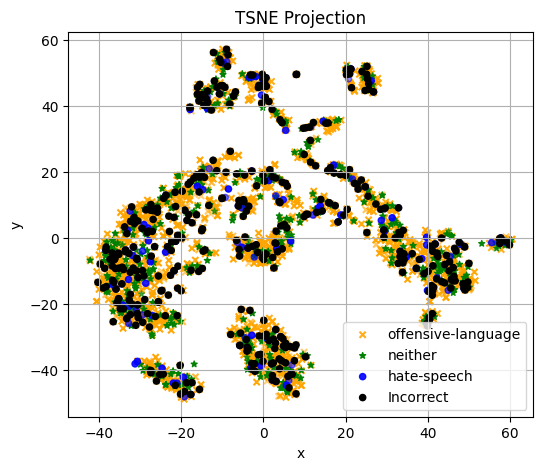

In [107]:
true_labels = df_output['true_label'].unique()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

for (label, marker) in zip(true_labels, ['x', '*', 'o']):
    df = df_output.loc[df_output['true_label'] == label].reset_index(drop=True)
    color = df['true_label_color'].unique()[0]
    df.plot.scatter(
        x='x',
        y='y',
        c=df['true_label_color'],
        alpha=df['alphas'],
        ax=ax,
        label=label,
        marker=marker,
    )
    
# Incorrect
incorrect_df = df_output.loc[df_output['correct_indicator_color'] == 'black']
incorrect_df.plot.scatter(
    x='x',
    y='y',
    c=incorrect_df['correct_indicator_color'],
    label='Incorrect',
    ax=ax,
)
    
ax.grid()
ax.set_title('TSNE Projection')
fig.savefig('./tsne_projection.png', bbox_inches='tight', pad_inches=0.05)